In [1]:
import numpy as np  # this module handles arrays, but here we need it for its NaN value
import pandas as pd # this module contains a lot of tools for handling tabular data
from matplotlib import pyplot as plt
from salishsea_tools import evaltools as et
import datetime as dt
import os
import gsw
import pickle
import netCDF4 as nc
import cmocean
from scipy import stats as spst
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

## Load data and matched model output

In [2]:
modSourceDir= '/results2/SalishSea/nowcast-green.201905/'
modver='201905'
Chl_N=1.8 # Chl:N ratio
startYMD=(2015,1,1)
endYMD=(2018,12,31)

In [3]:
start_date = dt.datetime(startYMD[0],startYMD[1],startYMD[2])
end_date = dt.datetime(endYMD[0],endYMD[1],endYMD[2]) #dt.datetime(2019,6,30)

In [4]:
datestr='_'+start_date.strftime('%Y%m%d')+'_'+end_date.strftime('%Y%m%d')

In [5]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as mesh:
    tmask=np.copy(mesh.variables['tmask'][0,:,:,:])
    navlat=np.copy(mesh.variables['nav_lat'][:,:])
    navlon=np.copy(mesh.variables['nav_lon'][:,:])

<ipython-input-5-e8c25931f5de>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tmask=np.copy(mesh.variables['tmask'][0,:,:,:])
<ipython-input-5-e8c25931f5de>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  navlat=np.copy(mesh.variables['nav_lat'][:,:])
<ipython-input-5-e8c25931f5de>:4: DeprecationWarning: `np.bool` is a deprecated alias for the b

In [6]:
def subval(idf,colList):
    # first value in colList should be the column you are going to keep
    # follow with other columns that will be used to fill in when that column is NaN
    # in order of precedence
    if len(colList)==2:
        idf[colList[0]]=[r[colList[0]] if not pd.isna(r[colList[0]]) \
                         else  r[colList[1]] for i,r in idf.iterrows()]
    elif len(colList)==3:
        idf[colList[0]]=[r[colList[0]] if not pd.isna(r[colList[0]]) \
                         else  r[colList[1]] if not pd.isna(r[colList[1]]) \
                         else r[colList[2]] for i,r in idf.iterrows()]
    else:
        raise NotImplementedError('Add to code to handle this case')
    idf.drop(columns=list(colList[1:]),inplace=True)
    return idf

In [9]:
if os.path.isfile('matched_'+modver+datestr+'_NewALLO.pkl'):
    data=pickle.load(open( 'matched_'+modver+datestr+'_NewALLO.pkl', 'rb' ) )
else:
    # define paths to the source files and eventual output file
    flist=('/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2015_NewALLO.csv',
           '/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2016_NewALLO.csv',
           '/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2017_NewALLO.csv',
           '/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2018_NewALLO.csv')#,
           #'/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2019.csv')

    dfs=list()
    for fname in flist:
        idf=pd.read_csv(fname)
        print(fname,sorted(idf.keys()))
        dfs.append(idf)
    df=pd.concat(dfs,ignore_index=True,sort=False); # concatenate the list into a single table

    df.drop(labels=['ADM:MISSION','ADM:PROJECT','ADM:SCIENTIST','Zone','Zone.1','Temperature:Draw',
                    'Temperature:Draw [deg C (ITS90)]','Bottle:Firing_Sequence','Comments by sample_numbeR',
                    'File Name','LOC:EVENT_NUMBER','Number_of_bin_records'
                       ],axis=1,inplace=True)

    #df=subval(df,('Dictyochophytes','Dictyo'))
    df=subval(df,('Chlorophyll:Extracted [mg/m^3]','Chlorophyll:Extracted'))
    #df=subval(df,('Dinoflagellates','Dinoflagellates-1'))
    df=subval(df,('Fluorescence [mg/m^3]','Fluorescence:URU:Seapoint [mg/m^3]','Fluorescence:URU:Seapoint'))
    df=subval(df,('Lat','LOC:LATITUDE'))
    df=subval(df,('Lon','LOC:LONGITUDE'))
    df=subval(df,('Nitrate_plus_Nitrite [umol/L]','Nitrate_plus_Nitrite'))
    df=subval(df,('PAR [uE/m^2/sec]','PAR'))
    df=subval(df,('Phaeo-Pigment:Extracted [mg/m^3]','Phaeo-Pigment:Extracted'))
    df=subval(df,('Phosphate [umol/L]','Phosphate'))
    df=subval(df,('Pressure [decibar]','Pressure'))
    #df=subval(df,('Raphidophytes','Raphido'))
    df=subval(df,('Salinity','Salinity [PSS-78]','Salinity:T1:C1 [PSS-78]'))
    df=subval(df,('Salinity:Bottle','Salinity:Bottle [PSS-78]'))
    df=subval(df,('Silicate [umol/L]','Silicate'))
    #df=subval(df,('TchlA (ug/L)','TchlA'))
    df=subval(df,('Temperature','Temperature [deg C (ITS90)]','Temperature:Secondary [deg C (ITS90)]'))
    df=subval(df,('Transmissivity [*/metre]','Transmissivity'))

    df['Z']=np.where(pd.isna(df['Depth [metres]']),
                     -1*gsw.z_from_p(df['Pressure [decibar]'].values,df['Lat'].values),
                     df['Depth [metres]'])
    df['p']=np.where(pd.isna(df['Pressure [decibar]']),
                     gsw.p_from_z(-1*df['Depth [metres]'].values,df['Lat'].values),
                    df['Pressure [decibar]'])
    df['SA']=gsw.SA_from_SP(df['Salinity'].values,df['p'].values,df['Lon'].values,df['Lat'].values)
    df['CT']=gsw.CT_from_t(df['SA'].values,df['Temperature'].values,df['p'].values)
    df.rename({'TchlA':'TchlA (ug/L)','Raphido':'Raphidophytes','Dinoflagellates-1':'Dinoflagellates',
            'Dictyo':'Dictyochophytes'},axis=1, inplace=True, errors='raise')
    df['dtUTC']=[dt.datetime.strptime(ii,'%Y-%m-%d %H:%M:%S') if isinstance(ii,str) else np.nan for ii in df['FIL:START TIME YYYY/MM/DD HH:MM:SS'] ]

    PATH= modSourceDir

    flen=1
    namfmt='nowcast'
    #varmap={'N':'nitrate','Si':'silicon','Ammonium':'ammonium'}
    filemap={'nitrate':'ptrc_T','silicon':'ptrc_T','ammonium':'ptrc_T','diatoms':'ptrc_T','ciliates':'ptrc_T','flagellates':'ptrc_T','vosaline':'grid_T','votemper':'grid_T'}
    #gridmap={'nitrate':'tmask','silicon':'tmask','ammonium':'tmask'}
    fdict={'ptrc_T':1,'grid_T':1}

    data=et.matchData(df,filemap,fdict,start_date,end_date,namfmt,PATH,flen)

    with open('matched_'+modver+datestr+'_NewALLO.pkl','wb') as f:
        pickle.dump(data,f)

/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2015_NewALLO.csv ['ADM:SCIENTIST', 'Chlorophyll:Extracted', 'Cruise', 'Cryptophytes', 'Cyanobacteria', 'Diatoms-1', 'Diatoms-2', 'Dictyo', 'Dinoflagellates-1', 'FIL:START TIME YYYY/MM/DD HH:MM:SS', 'File Name', 'Flag:Chlorophyll:Extracted', 'Flag:Nitrate_plus_Nitrite', 'Flag:Oxygen:Dissolved', 'Flag:Phosphate', 'Flag:Salinity:Bottle', 'Flag:Silicate', 'Fluorescence:URU:Seapoint', 'Haptophytes', 'LOC:EVENT_NUMBER', 'LOC:STATION', 'LOC:WATER DEPTH', 'Lat', 'Lon', 'Nitrate_plus_Nitrite', 'Number_of_bin_records', 'Oxygen:Dissolved', 'Oxygen:Dissolved:CTD', 'PAR', 'Phaeo-Pigment:Extracted', 'Phosphate', 'Prasinophytes', 'Pressure', 'Raphido', 'Salinity', 'Salinity:Bottle', 'Sample_Number', 'Silicate', 'TchlA', 'Temperature', 'Temperature:Draw', 'Transmissivity', 'Zone', 'pH:SBE:Nominal']
/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2016_NewALLO.csv ['ADM:PROJECT', 'ADM:SCIENTIST', 'Bottle:Firing_Sequence', 'Bottle_Number', 'Chloro

In [10]:
data['other']=0.0
for el in ('Cryptophytes', 'Cyanobacteria', 'Dictyochophytes', 'Dinoflagellates',
    'Haptophytes', 'Prasinophytes', 'Raphidophytes'):
    data['other']=data['other']+data[el]

In [11]:
def yd(idt):
    if type(idt)==dt.datetime:
        yd=(idt-dt.datetime(idt.year-1,12,31)).days
    else: # assume array or pandas
        yd=[(ii-dt.datetime(ii.year-1,12,31)).days for ii in idt]
    return yd

data['yd']=yd(data['dtUTC'])
data['Year']=[ii.year for ii in data['dtUTC']]

In [12]:
# define log transform function with slight shift to accommodate zero values
def logt(x):
    return np.log10(x+.001)

### What do HPLC-based obs look like in terms of species composition?

In [13]:
hplclist=('Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
           'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes')

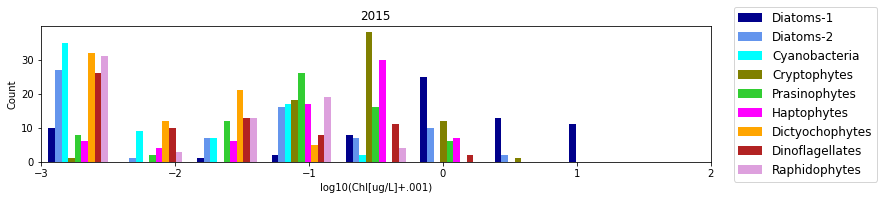

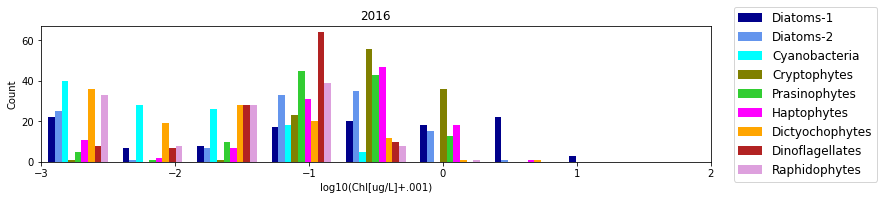

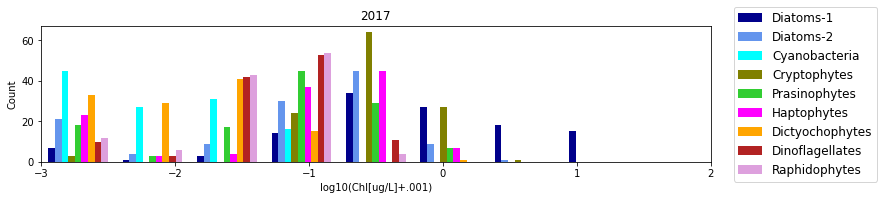

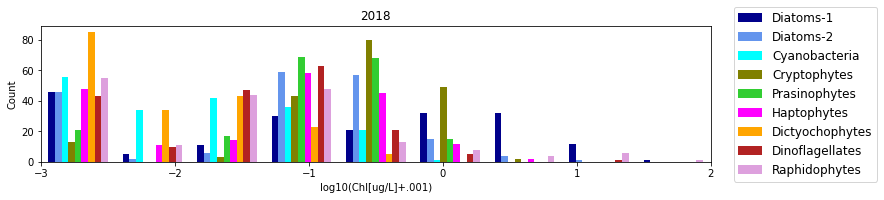

In [14]:
### Histogram by Year:
for year in range(2015,2019):
    fig,ax=plt.subplots(1,1,figsize=(12,2.5))
    hplclist=('Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
           'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes')
    x=np.array([logt(data[data.Year==year][el]) for el in hplclist]).T
    cols=('darkblue','cornflowerblue','cyan','olive','limegreen','magenta','orange','firebrick','plum')
    bins=np.linspace(-3,2,10)
    ax.hist(x, bins, density=False, histtype='bar', color=cols, label=hplclist);
    fig.legend(prop={'size': 12},loc='center right',bbox_to_anchor=[1.1,.5,0,0]);
    ax.set_xlim(-3,2)
    ax.set_xlabel('log10(Chl[ug/L]+.001)')
    ax.set_ylabel('Count')
    ax.set_title(year)

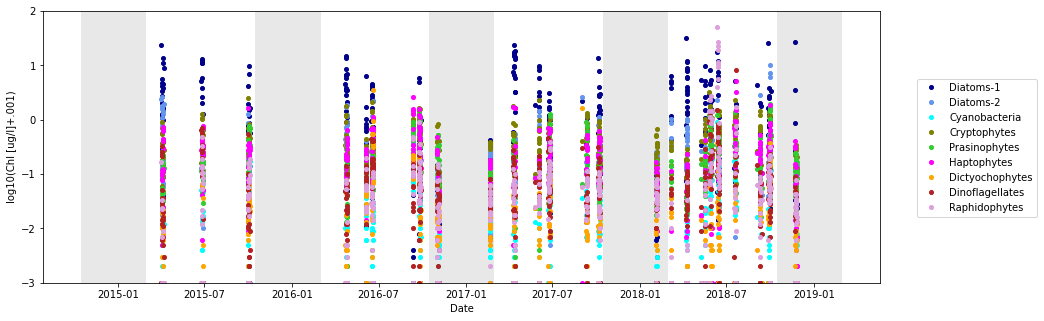

In [15]:
x=np.array([logt(data[el]) for el in hplclist]).T
fig,ax=plt.subplots(1,1,figsize=(15,5))
for i in range(0,len(hplclist)):
    ax.plot(data['dtUTC'],x[:,i],'o',color=cols[i],label=hplclist[i],ms=4)
fig.legend(loc='center right',bbox_to_anchor=[1.05,.5])
ax.set_ylim(-3,2)
ax.set_xlabel('Date')
ax.set_ylabel('log10(Chl [ug/l]+.001)')
for i in range(2015,2020):
    ax.axvspan(dt.datetime(i-1,10,15),dt.datetime(i,3,1), facecolor='lightgrey', alpha=0.5)

## Model vs Obs Plots for various model-obs groups

(0.0, 8.0)

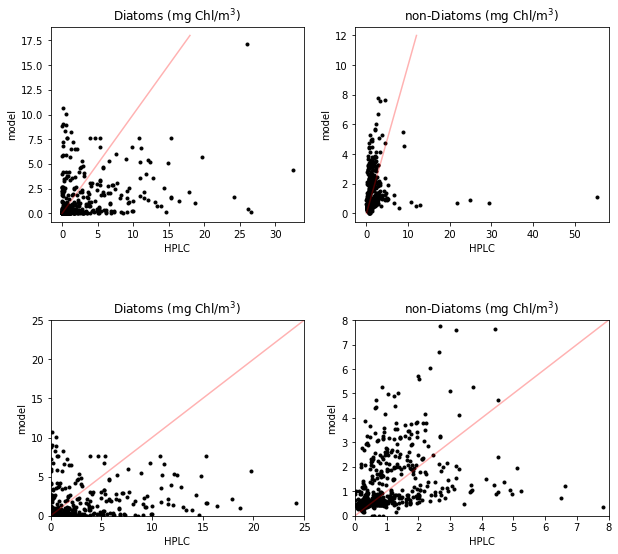

In [16]:
fig,ax=plt.subplots(2,2,figsize=(10,9))
fig.subplots_adjust(hspace=.5)
ax=ax.flatten()
ax[0].plot(data['Diatoms-1']+data['Diatoms-2'],Chl_N*data['mod_diatoms'],'k.')
ax[0].set_title('Diatoms (mg Chl/m$^3$)')
ax[0].set_xlabel('HPLC')
ax[0].set_ylabel('model')
ax[0].plot((0,18),(0,18),'r-',alpha=.3)

ax[1].plot(data['other'],Chl_N*(data['mod_flagellates']+data['mod_ciliates']),'k.')
ax[1].set_title('non-Diatoms (mg Chl/m$^3$)')
ax[1].set_xlabel('HPLC')
ax[1].set_ylabel('model')
ax[1].plot((0,12),(0,12),'r-',alpha=.3)

ax[2].plot(data['Diatoms-1']+data['Diatoms-2'],Chl_N*data['mod_diatoms'],'k.')
ax[2].set_title('Diatoms (mg Chl/m$^3$)')
ax[2].set_xlabel('HPLC')
ax[2].set_ylabel('model')
ax[2].plot((0,25),(0,25),'r-',alpha=.3)
ax[2].set_xlim((0,25))
ax[2].set_ylim((0,25))

ax[3].plot(data['other'],Chl_N*(data['mod_flagellates']+data['mod_ciliates']),'k.')
ax[3].set_title('non-Diatoms (mg Chl/m$^3$)')
ax[3].set_xlabel('HPLC')
ax[3].set_ylabel('model')
ax[3].plot((0,12),(0,12),'r-',alpha=.3)
ax[3].set_xlim((0,8))
ax[3].set_ylim((0,8))

(-3.1, 2.0)

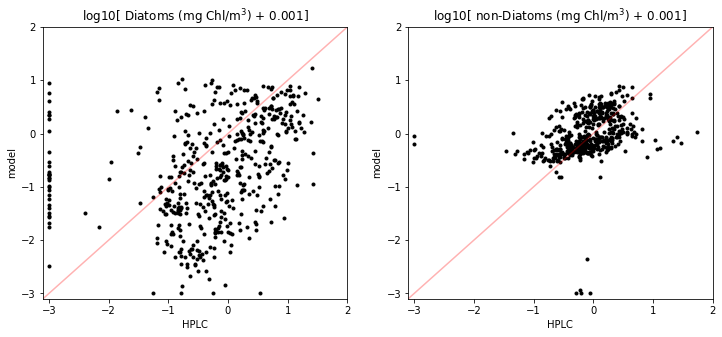

In [17]:
# log-log model vs obs
fig,ax=plt.subplots(1,2,figsize=(12,5))
ax[0].plot(logt(data['Diatoms-1']+data['Diatoms-2']),logt(Chl_N*data['mod_diatoms']),'k.')
ax[0].set_title('log10[ Diatoms (mg Chl/m$^3$) + 0.001]')
ax[0].set_xlabel('HPLC')
ax[0].set_ylabel('model')
ax[0].set_xlim(-3.1,2)
ax[0].set_ylim(-3.1,2)
ax[0].plot((-6,3),(-6,3),'r-',alpha=.3)

ax[1].plot(logt(data['other']),logt(Chl_N*(data['mod_flagellates']+data['mod_ciliates'])),'k.')
ax[1].set_title('log10[ non-Diatoms (mg Chl/m$^3$) + 0.001]')
ax[1].set_xlabel('HPLC')
ax[1].set_ylabel('model')
ax[1].plot((-6,3),(-6,3),'r-',alpha=.3)
ax[1].set_xlim(-3.1,2)
ax[1].set_ylim(-3.1,2)

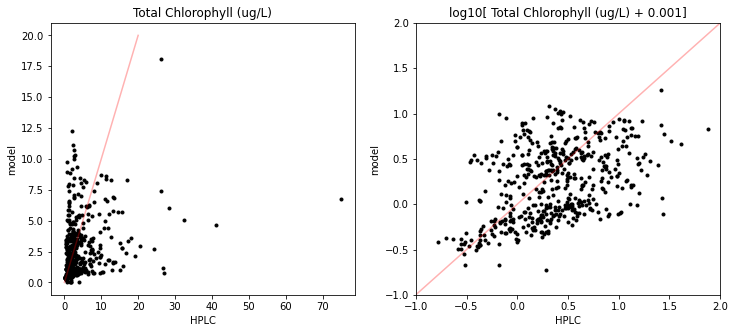

In [18]:
# total chlorophyll comparisons

fig,ax=plt.subplots(1,2,figsize=(12,5))
ax[0].plot(data['TchlA (ug/L)'],Chl_N*(data['mod_flagellates']+data['mod_ciliates']+data['mod_diatoms']),'k.')
ax[0].set_title('Total Chlorophyll (ug/L)')
ax[0].set_xlabel('HPLC')
ax[0].set_ylabel('model')
ax[0].plot((0,20),(0,20),'r-',alpha=.3)

ax[1].plot(logt(data['TchlA (ug/L)']),logt(Chl_N*(data['mod_flagellates']+data['mod_ciliates']+data['mod_diatoms'])),'k.')
ax[1].set_title('log10[ Total Chlorophyll (ug/L) + 0.001]')
ax[1].set_xlabel('HPLC')
ax[1].set_ylabel('model')
ax[1].plot((-6,5),(-6,5),'r-',alpha=.3)
ax[1].set_xlim(-1,2)
ax[1].set_ylim(-1,2);

### By time of year

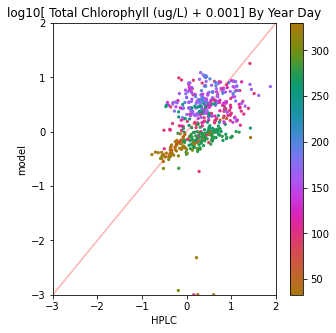

In [19]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
m=ax.scatter(logt(data['TchlA (ug/L)']),logt(Chl_N*(data['mod_flagellates']+data['mod_ciliates']+data['mod_diatoms'])),
          c=data['yd'],s=5,cmap=cmocean.cm.phase)
ax.set_title('log10[ Total Chlorophyll (ug/L) + 0.001] By Year Day')
ax.set_xlabel('HPLC')
ax.set_ylabel('model')
ax.plot((-6,5),(-6,5),'r-',alpha=.3)
ax.set_xlim(-3,2)
ax.set_ylim(-3,2);
fig.colorbar(m)

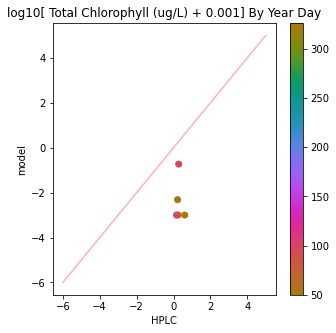

In [20]:
# look specifically at points where HPLC level is high and model level is low
x=logt(data['TchlA (ug/L)'])
y=logt(Chl_N*(data['mod_flagellates']+data['mod_ciliates']+data['mod_diatoms']))
ii=data.loc[(y<-.5)&(x>0)].index

fig,ax=plt.subplots(1,1,figsize=(5,5))
m=ax.scatter(logt(data.loc[ii,['TchlA (ug/L)']].values),
             logt(Chl_N*(data.loc[ii,['mod_flagellates']].values+data.loc[ii,['mod_ciliates']].values+\
                         data.loc[ii,['mod_diatoms']].values)),
          c=data.loc[ii,['yd']].values,cmap=cmocean.cm.phase)
ax.set_title('log10[ Total Chlorophyll (ug/L) + 0.001] By Year Day')
ax.set_xlabel('HPLC')
ax.set_ylabel('model')
ax.plot((-6,5),(-6,5),'r-',alpha=.3)
#ax.set_xlim(-3,2)
#ax.set_ylim(-3,2);
fig.colorbar(m)

In [21]:
temp=data.loc[(y<-.5)&(data['Diatoms-1']>=0),['dtUTC','Sample_Number','i','j','k','p','FIL:START TIME YYYY/MM/DD HH:MM:SS','TchlA (ug/L)','Diatoms-1','mod_diatoms','mod_ciliates','mod_flagellates']].copy(deep=True)

In [22]:
temp['x']=logt(temp['TchlA (ug/L)'])
temp['y']=logt(Chl_N*(temp['mod_flagellates']+temp['mod_ciliates']+temp['mod_diatoms']))
temp

,dtUTC,Sample_Number,i,j,k,p,FIL:START TIME YYYY/MM/DD HH:MM:SS,TchlA (ug/L),Diatoms-1,mod_diatoms,mod_ciliates,mod_flagellates,x,y
2058,2016-10-31 08:52:26,39.0,7,413,1,1.700000,2016-10-31 08:52:26,0.649,0.014,2.308997e-05,3.474708e-05,5.449354e-05,-0.187087,-2.920025
2124,2016-11-01 09:40:15,105.0,292,344,1,1.500000,2016-11-01 09:40:15,0.395,0.049,6.729010e-03,9.051096e-02,7.388679e-02,-0.402305,-0.510002
2221,2016-11-04 03:16:00,221.0,129,725,2,2.300000,2016-11-04 03:16:00,0.301,0.011,1.026475e-02,5.436243e-02,5.191729e-02,-0.519993,-0.676170
2325,2017-02-19 07:07:56,615.0,7,413,0,1.000000,2017-02-19 07:07:56,1.774,0.153,3.733047e-08,1.180228e-06,3.594524e-06,0.249198,-2.996254
2539,2017-04-09 15:48:00,24.0,7,413,1,1.109361,2017-04-09 15:48:00,1.446,0.395,1.046590e-08,1.017922e-08,1.043058e-08,0.160469,-2.999976
2554,2017-04-09 18:34:00,39.0,31,394,0,1.008507,2017-04-09 18:34:00,1.902,0.397,1.677416e-02,2.761524e-02,5.814350e-02,0.279439,-0.731517
3647,2017-10-08 11:07:14,304.0,129,725,1,1.400000,2017-10-08 11:07:14,0.665,0.344,3.482530e-02,4.179447e-02,4.104664e-02,-0.176526,-0.672029
5321,2018-11-22 18:37:56,37.0,8,413,2,2.600000,2018-11-22 18:37:56,4.033,3.509,1.005235e-08,1.009910e-08,1.024531e-08,0.605736,-2.999976
5335,2018-11-22 22:19:58,51.0,31,394,1,1.900000,2018-11-22 22:19:58,1.659,0.885,2.614201e-04,7.575854e-04,1.107582e-03,0.220108,-2.316246
5577,2018-11-25 18:53:49,297.0,142,699,2,2.700000,2018-11-25 18:53:49,0.300,0.006,1.960240e-02,6.811737e-02,6.847256e-02,-0.521434,-0.549526


#### Where are these points in domain?

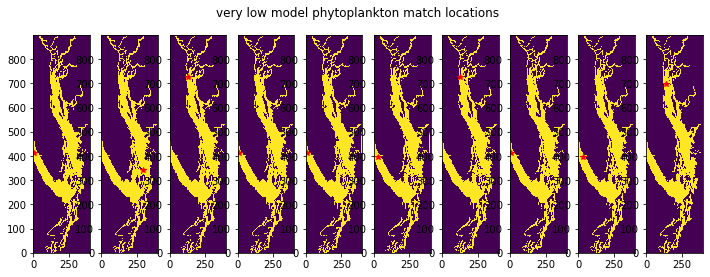

In [23]:
ilen=len(temp)
fig,ax=plt.subplots(1,ilen,figsize=(12,4))
indlist=temp.index
for i in range(0,ilen):
    ax[i].pcolormesh(tmask[0,:,:])
    ax[i].plot(temp.loc[indlist[i],['i']],temp.loc[indlist[i],['j']],'r*')
fig.suptitle('very low model phytoplankton match locations');

## Multiple Linear Regression

#### Diatoms

In [24]:
ii=(~pd.isnull(data['mod_diatoms']))&(~pd.isnull(data['Diatoms-1']))&(~pd.isnull(data['Diatoms-2']))&(~pd.isnull(data['Cyanobacteria']))&\
        (~pd.isnull(data['Cryptophytes']))&(~pd.isnull(data['Prasinophytes']))&(~pd.isnull(data['Haptophytes']))&\
        (~pd.isnull(data['Dictyochophytes']))&(~pd.isnull(data['Dinoflagellates']))&(~pd.isnull(data['Raphidophytes']))
A=np.vstack([data.loc[ii]['Diatoms-1'],data.loc[ii]['Diatoms-2'],data.loc[ii]['Cyanobacteria'],data.loc[ii]['Cryptophytes'],
               data.loc[ii]['Prasinophytes'],data.loc[ii]['Haptophytes'],data.loc[ii]['Dictyochophytes'],data.loc[ii]['Dinoflagellates'],
             data.loc[ii]['Raphidophytes'],np.ones(np.shape(data.loc[ii]['Diatoms-1']))]).T
b=data.loc[ii]['mod_diatoms']
m=np.linalg.lstsq(A,b,rcond=None)[0]

In [25]:
m

array([ 0.07901177,  0.04038303, -2.37059036,  0.82620416, -0.80017277,
       -0.00327047, -0.28365716, -0.05637489,  0.08471479,  0.34857395])

In [26]:
clist=('Diatoms-1','Diatoms-2','Cyanobacteria','Cryptophytes','Prasinophytes','Haptophytes',
        'Dictyochophytes','Dinoflagellates','Raphidophytes','ones')
for c, mm in zip(clist,m):
    print(c,mm)

Diatoms-1 0.07901176679205403
Diatoms-2 0.04038302960024198
Cyanobacteria -2.3705903602264917
Cryptophytes 0.8262041629489276
Prasinophytes -0.8001727730681525
Haptophytes -0.003270465217090235
Dictyochophytes -0.2836571600122384
Dinoflagellates -0.056374894317614846
Raphidophytes 0.08471478644049679
ones 0.34857395106817046


#### try again with a subset that showed some correlation (and diatoms-2):

In [27]:
ii=(~pd.isnull(data['mod_diatoms']))&(~pd.isnull(data['Diatoms-1']))&(~pd.isnull(data['Diatoms-2']))&\
        (~pd.isnull(data['Cryptophytes']))&(~pd.isnull(data['Raphidophytes']))
A=np.vstack([data.loc[ii]['Diatoms-1'],data.loc[ii]['Diatoms-2'],data.loc[ii]['Cryptophytes'],
            data.loc[ii]['Raphidophytes'],np.ones(np.shape(data.loc[ii]['Diatoms-1']))]).T
b=data.loc[ii]['mod_diatoms']
m=np.linalg.lstsq(A,b,rcond=None)[0]

In [28]:
clist=('Diatoms-1','Diatoms-2','Cryptophytes','Raphidophytes','ones')
for c, mm in zip(clist,m):
    print(c,mm)

Diatoms-1 0.08993110228472322
Diatoms-2 0.014188091706788641
Cryptophytes 0.3389072106820919
Raphidophytes 0.04688692509711265
ones 0.2897009806718322


In [29]:
ii=(~pd.isnull(data['mod_diatoms']))&(~pd.isnull(data['Diatoms-1']))&\
        (~pd.isnull(data['Cryptophytes']))&(~pd.isnull(data['Raphidophytes']))
A=np.vstack([data.loc[ii]['Diatoms-1'],data.loc[ii]['Cryptophytes'],
            data.loc[ii]['Raphidophytes'],np.ones(np.shape(data.loc[ii]['Diatoms-1']))]).T
b=data.loc[ii]['mod_diatoms']
m=np.linalg.lstsq(A,b,rcond=None)[0]

In [30]:
clist=('Diatoms-1','Cryptophytes','Raphidophytes','ones')
for c, mm in zip(clist,m):
    print(c,mm)

Diatoms-1 0.09024331276536572
Cryptophytes 0.3406248379075281
Raphidophytes 0.04707605924340086
ones 0.2924781243022796


#### flagellates

In [31]:
ii=(~pd.isnull(data['mod_flagellates']))&(~pd.isnull(data['Diatoms-1']))&(~pd.isnull(data['Diatoms-2']))&(~pd.isnull(data['Cyanobacteria']))&\
        (~pd.isnull(data['Cryptophytes']))&(~pd.isnull(data['Prasinophytes']))&(~pd.isnull(data['Haptophytes']))&\
        (~pd.isnull(data['Dictyochophytes']))&(~pd.isnull(data['Dinoflagellates']))&(~pd.isnull(data['Raphidophytes']))
A=np.vstack([data.loc[ii]['Diatoms-1'],data.loc[ii]['Diatoms-2'],data.loc[ii]['Cyanobacteria'],data.loc[ii]['Cryptophytes'],
               data.loc[ii]['Prasinophytes'],data.loc[ii]['Haptophytes'],data.loc[ii]['Dictyochophytes'],data.loc[ii]['Dinoflagellates'],
             data.loc[ii]['Raphidophytes'],np.ones(np.shape(data.loc[ii]['Diatoms-1']))]).T
b=data.loc[ii]['mod_flagellates']
m=np.linalg.lstsq(A,b,rcond=None)[0]

In [32]:
m

array([-0.00191036, -0.16480308,  1.82122949,  0.17455955,  0.11920028,
        0.35375115,  0.27956835,  0.23419722, -0.04018753,  0.35021653])

In [33]:
clist=('Diatoms-1','Diatoms-2','Cyanobacteria','Cryptophytes','Prasinophytes','Haptophytes',
        'Dictyochophytes','Dinoflagellates','Raphidophytes','ones')
for c, mm in zip(clist,m):
    print(c,mm)

Diatoms-1 -0.0019103589958024306
Diatoms-2 -0.16480307826918028
Cyanobacteria 1.821229487184655
Cryptophytes 0.17455954744634916
Prasinophytes 0.11920028329070938
Haptophytes 0.35375115362128273
Dictyochophytes 0.27956835348460174
Dinoflagellates 0.2341972205331308
Raphidophytes -0.04018752832367504
ones 0.3502165306381572


In [34]:
ii=(~pd.isnull(data['mod_flagellates']))&(~pd.isnull(data['Diatoms-1']))&(~pd.isnull(data['Cyanobacteria']))&\
        (~pd.isnull(data['Cryptophytes']))&(~pd.isnull(data['Prasinophytes']))&(~pd.isnull(data['Haptophytes']))&\
        (~pd.isnull(data['Dictyochophytes']))&(~pd.isnull(data['Dinoflagellates']))&(~pd.isnull(data['Raphidophytes']))
A=np.vstack([data.loc[ii]['Diatoms-1'],data.loc[ii]['Cyanobacteria'],data.loc[ii]['Cryptophytes'],
               data.loc[ii]['Prasinophytes'],data.loc[ii]['Haptophytes'],data.loc[ii]['Dictyochophytes'],
             data.loc[ii]['Dinoflagellates'],np.ones(np.shape(data.loc[ii]['Diatoms-1']))]).T
b=data.loc[ii]['mod_flagellates']
m=np.linalg.lstsq(A,b,rcond=None)[0]

In [35]:
clist=('Diatoms-1','Cyanobacteria','Cryptophytes','Prasinophytes','Haptophytes',
        'Dictyochophytes','Dinoflagellates','ones')
for c, mm in zip(clist,m):
    print(c,mm)

Diatoms-1 -0.010844167278902635
Cyanobacteria 0.78933658843036
Cryptophytes 0.14766098991975396
Prasinophytes 0.21859616028611023
Haptophytes 0.38112414890833923
Dictyochophytes 0.14293751829866547
Dinoflagellates 0.19024925143696172
ones 0.33693420147988185


In [36]:
ii=(~pd.isnull(data['mod_flagellates']))&(~pd.isnull(data['Cyanobacteria']))&\
        (~pd.isnull(data['Cryptophytes']))&(~pd.isnull(data['Prasinophytes']))&(~pd.isnull(data['Haptophytes']))&\
        (~pd.isnull(data['Dictyochophytes']))&(~pd.isnull(data['Raphidophytes']))
A=np.vstack([data.loc[ii]['Cyanobacteria'],data.loc[ii]['Cryptophytes'],
               data.loc[ii]['Prasinophytes'],data.loc[ii]['Haptophytes'],data.loc[ii]['Dictyochophytes'],
             np.ones(np.shape(data.loc[ii]['Diatoms-1']))]).T
b=data.loc[ii]['mod_flagellates']
m=np.linalg.lstsq(A,b,rcond=None)[0]

In [37]:
clist=('Cyanobacteria','Cryptophytes','Prasinophytes','Haptophytes',
        'Dictyochophytes','ones')
for c, mm in zip(clist,m):
    print(c,mm)

Cyanobacteria 0.858602872673889
Cryptophytes 0.17220455649899657
Prasinophytes 0.21819670508290173
Haptophytes 0.37773976424820205
Dictyochophytes 0.1736729736655534
ones 0.3188227556509651


#### M. rubrum

In [38]:
ii=(~pd.isnull(data['mod_ciliates']))&(~pd.isnull(data['Diatoms-1']))&(~pd.isnull(data['Diatoms-2']))&(~pd.isnull(data['Cyanobacteria']))&\
        (~pd.isnull(data['Cryptophytes']))&(~pd.isnull(data['Prasinophytes']))&(~pd.isnull(data['Haptophytes']))&\
        (~pd.isnull(data['Dictyochophytes']))&(~pd.isnull(data['Dinoflagellates']))&(~pd.isnull(data['Raphidophytes']))
A=np.vstack([data.loc[ii]['Diatoms-1'],data.loc[ii]['Diatoms-2'],data.loc[ii]['Cyanobacteria'],data.loc[ii]['Cryptophytes'],
               data.loc[ii]['Prasinophytes'],data.loc[ii]['Haptophytes'],data.loc[ii]['Dictyochophytes'],data.loc[ii]['Dinoflagellates'],
             data.loc[ii]['Raphidophytes'],np.ones(np.shape(data.loc[ii]['Diatoms-1']))]).T
b=data.loc[ii]['mod_ciliates']
m=np.linalg.lstsq(A,b,rcond=None)[0]

In [39]:
clist=('Diatoms-1','Diatoms-2','Cyanobacteria','Cryptophytes','Prasinophytes','Haptophytes',
        'Dictyochophytes','Dinoflagellates','Raphidophytes','ones')
for c, mm in zip(clist,m):
    print(c,mm)

Diatoms-1 0.00271483118441355
Diatoms-2 -0.002480924214265573
Cyanobacteria 0.17168436679777188
Cryptophytes 0.014840160738755881
Prasinophytes -0.05407508103203415
Haptophytes 0.012012902440612174
Dictyochophytes -0.02010500713099727
Dinoflagellates 0.007809010638318125
Raphidophytes -0.002067711074437012
ones 0.18167953620171418


Diatoms:
- Cryptophytes 
- Diatoms-1 
- Raphidophytes 

Flagellates:
- Cyanobacteria 
- Cryptophytes 
- Prasinophytes
- Haptophytes
- maybe dinoflagellates
- cyanobacteria make up small fraction of abundance; Nina says leave out

M. rubrum:
- Cyanobacteria

None:
- Diatoms-2
- Dictyochophytes
- Dinoflagellates?

##### Nina says Do not include cyanos in flagellate-like group: they are not flagellates and their abundance is low

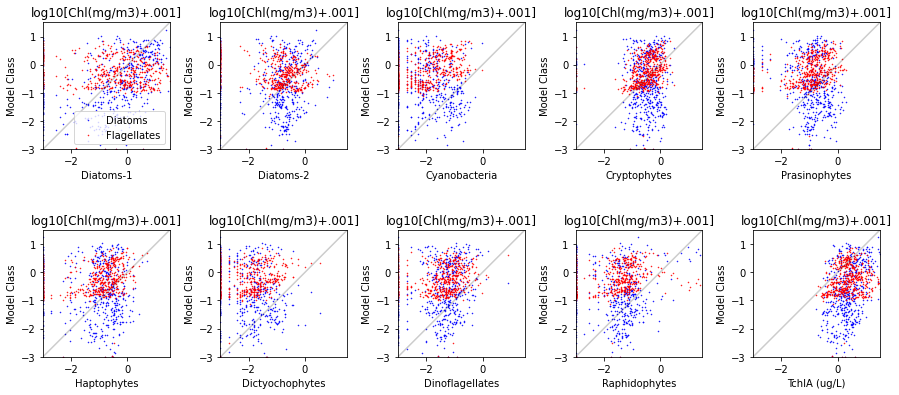

In [40]:
fig,ax=plt.subplots(2,5,figsize=(15,7))
fig.subplots_adjust(wspace=.4)
ax=ax.flatten()

chplc=('Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
       'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes','TchlA (ug/L)')

mvar1=Chl_N*data['mod_diatoms']
mvar2=Chl_N*data['mod_flagellates']

for ii in range(0,len(chplc)):
    ax[ii].plot(logt(data.loc[:,[chplc[ii]]].values),logt(mvar1),'.',ms=1,color='blue',label='Diatoms')
    ax[ii].plot(logt(data.loc[:,[chplc[ii]]].values),logt(mvar2),'.',ms=1,color='red',label='Flagellates')
    ax[ii].set_ylabel('Model Class')
    ax[ii].set_xlabel(chplc[ii])
    ax[ii].set_title('log10[Chl(mg/m3)+.001]')
    ax[ii].plot((-3,1.5),(-3,1.5),'k-',alpha=.2)
    ax[ii].set_xlim((-3,1.5))
    ax[ii].set_ylim((-3,1.5))
    ax[ii].set_aspect(1)
ax[0].legend()


(-3.0, 1.5)

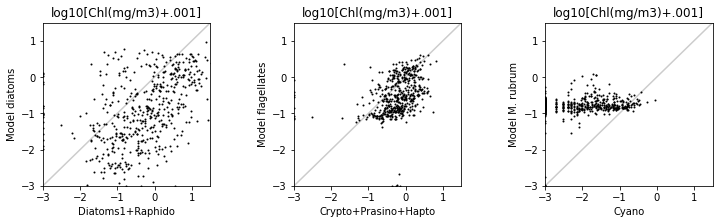

In [41]:
fig,ax=plt.subplots(1,3,figsize=(12,3))
fig.subplots_adjust(wspace=.5)
#ax[0].plot(logt(data['Diatoms-1']+data['Raphidophytes']+.5*data['Cryptophytes']),logt(data['mod_diatoms']),'r.')
ax[0].plot(logt(data['Diatoms-1']+data['Raphidophytes']),logt(data['mod_diatoms']),'k.',ms=2)
ax[0].set_ylabel('Model diatoms')
ax[0].set_xlabel('Diatoms1+Raphido')
ax[0].set_title('log10[Chl(mg/m3)+.001]')
ax[0].plot((-3,1.5),(-3,1.5),'k-',alpha=.2)
ax[0].set_xlim((-3,1.5))
ax[0].set_ylim((-3,1.5))

ax[1].plot(logt(data['Cryptophytes']+data['Prasinophytes']+data['Haptophytes']),logt(data['mod_flagellates']),'k.',ms=2)
ax[1].set_ylabel('Model flagellates')
ax[1].set_xlabel('Crypto+Prasino+Hapto')
ax[1].set_title('log10[Chl(mg/m3)+.001]')
ax[1].plot((-3,1.5),(-3,1.5),'k-',alpha=.2)
ax[1].set_xlim((-3,1.5))
ax[1].set_ylim((-3,1.5))


ax[2].plot(logt(data['Cyanobacteria']),logt(data['mod_ciliates']),'k.',ms=2)
ax[2].set_ylabel('Model M. rubrum')
ax[2].set_xlabel('Cyano')
ax[2].set_title('log10[Chl(mg/m3)+.001]')
ax[2].plot((-3,1.5),(-3,1.5),'k-',alpha=.2)
ax[2].set_xlim((-3,1.5))
ax[2].set_ylim((-3,1.5))

In [42]:
data['mod_diatoms_chl']=Chl_N*data['mod_diatoms']
data['mod_flagellates_chl']=Chl_N*data['mod_flagellates']
data['mod_ciliates_chl']=Chl_N*data['mod_ciliates']
data['mod_TChl']=data['mod_diatoms_chl']+data['mod_flagellates_chl']+data['mod_ciliates_chl']
data['CPH']=data['Cryptophytes']+data['Prasinophytes']+data['Haptophytes']
data['DD']=data['Diatoms-1']+data['Diatoms-2']
dfVars=data.loc[:,['Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
       'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes','DD','CPH','TchlA (ug/L)',
                   'mod_diatoms_chl','mod_flagellates_chl','mod_ciliates_chl','mod_TChl']]

### Variance-Covariance Matrix

In [43]:
dfVars.cov()

,Diatoms-1,Diatoms-2,Cyanobacteria,Cryptophytes,Prasinophytes,Haptophytes,Dictyochophytes,Dinoflagellates,Raphidophytes,DD,CPH,TchlA (ug/L),mod_diatoms_chl,mod_flagellates_chl,mod_ciliates_chl,mod_TChl
Diatoms-1,17.030227,0.383433,-0.014114,-0.180451,-0.176579,-0.147258,-0.029133,0.111324,2.290018,17.413661,-0.504288,19.195920,2.849766,-0.540311,0.080426,2.389881
Diatoms-2,0.383433,0.517381,0.004810,0.019841,0.008286,0.013027,0.027284,0.008542,0.191999,0.900814,0.041154,1.167819,0.103589,-0.119279,-0.000527,-0.016217
Cyanobacteria,-0.014114,0.004810,0.005901,0.014656,0.014236,0.008116,0.001919,0.003371,0.107947,-0.009303,0.037008,0.144586,-0.010456,0.025373,0.000491,0.015408
Cryptophytes,-0.180451,0.019841,0.014656,0.175789,0.072638,0.055288,0.004603,0.017336,0.189807,-0.160610,0.303715,0.355411,0.094552,0.144700,0.001750,0.241003
Prasinophytes,-0.176579,0.008286,0.014236,0.072638,0.075690,0.030017,0.005900,0.004749,0.158524,-0.168293,0.178345,0.184770,-0.065746,0.096499,-0.002015,0.028737
Haptophytes,-0.147258,0.013027,0.008116,0.055288,0.030017,0.158861,0.002099,-0.000856,-0.017002,-0.134231,0.244167,0.094285,-0.020153,0.150141,0.003696,0.133684
Dictyochophytes,-0.029133,0.027284,0.001919,0.004603,0.005900,0.002099,0.034487,0.005154,0.040856,-0.001849,0.012603,0.091620,-0.023915,0.018919,-0.001405,-0.006401
Dinoflagellates,0.111324,0.008542,0.003371,0.017336,0.004749,-0.000856,0.005154,0.155056,0.263792,0.119866,0.021229,0.566188,0.042876,0.062930,0.002541,0.108347
Raphidophytes,2.290018,0.191999,0.107947,0.189807,0.158524,-0.017002,0.040856,0.263792,8.899071,2.482017,0.331329,12.107873,1.242441,-0.140106,0.002073,1.104408
DD,17.413661,0.900814,-0.009303,-0.160610,-0.168293,-0.134231,-0.001849,0.119866,2.482017,18.314475,-0.463135,20.363739,2.953355,-0.659590,0.079900,2.373664


### Correlation Coefficient Matrix

In [44]:
dfVars.corr()

,Diatoms-1,Diatoms-2,Cyanobacteria,Cryptophytes,Prasinophytes,Haptophytes,Dictyochophytes,Dinoflagellates,Raphidophytes,DD,CPH,TchlA (ug/L),mod_diatoms_chl,mod_flagellates_chl,mod_ciliates_chl,mod_TChl
Diatoms-1,1.000000,0.129174,-0.044520,-0.104293,-0.155529,-0.089528,-0.038014,0.068507,0.186019,0.986013,-0.143394,0.799078,0.329545,-0.107524,0.086555,0.240522
Diatoms-2,0.129174,1.000000,0.087055,0.065789,0.041872,0.045439,0.204256,0.030159,0.089479,0.292639,0.067138,0.278908,0.068727,-0.136186,-0.003254,-0.009364
Cyanobacteria,-0.044520,0.087055,1.000000,0.455047,0.673585,0.265069,0.134517,0.111427,0.471045,-0.028299,0.565312,0.323326,-0.064953,0.271249,0.028373,0.083302
Cryptophytes,-0.104293,0.065789,0.455047,1.000000,0.629727,0.330846,0.059123,0.105006,0.151756,-0.089512,0.850031,0.145622,0.107619,0.283430,0.018542,0.238735
Prasinophytes,-0.155529,0.041872,0.673585,0.629727,1.000000,0.273744,0.115485,0.043839,0.193154,-0.142939,0.760689,0.115373,-0.114043,0.288055,-0.032531,0.043383
Haptophytes,-0.089528,0.045439,0.265069,0.330846,0.273744,1.000000,0.028364,-0.005455,-0.014300,-0.078695,0.718854,0.040637,-0.024129,0.309359,0.041182,0.139303
Dictyochophytes,-0.038014,0.204256,0.134517,0.059123,0.115485,0.028364,1.000000,0.070478,0.073749,-0.002326,0.079637,0.084752,-0.061454,0.083663,-0.033596,-0.014315
Dinoflagellates,0.068507,0.030159,0.111427,0.105006,0.043839,-0.005455,0.070478,1.000000,0.224567,0.071130,0.063264,0.247006,0.051962,0.131246,0.028659,0.114278
Raphidophytes,0.186019,0.089479,0.471045,0.151756,0.193154,-0.014300,0.073749,0.224567,1.000000,0.194417,0.130332,0.697246,0.198755,-0.038571,0.003086,0.153761
DD,0.986013,0.292639,-0.028299,-0.089512,-0.142939,-0.078695,-0.002326,0.071130,0.194417,1.000000,-0.126991,0.817431,0.329332,-0.126575,0.082919,0.230362


### Cov matrix with log transformed values:

In [45]:
dflog=pd.DataFrame()
for el in ['Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
       'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes','CPH','TchlA (ug/L)',
                   'mod_diatoms_chl','mod_flagellates_chl','mod_ciliates_chl','mod_TChl']:
    dflog[el]=logt(data[el])
dflog.cov()

,Diatoms-1,Diatoms-2,Cyanobacteria,Cryptophytes,Prasinophytes,Haptophytes,Dictyochophytes,Dinoflagellates,Raphidophytes,CPH,TchlA (ug/L),mod_diatoms_chl,mod_flagellates_chl,mod_ciliates_chl,mod_TChl
Diatoms-1,1.707049,0.223426,-0.191222,-0.156507,-0.337293,-0.224417,-0.022976,0.263191,-0.054699,-0.169667,0.364806,0.476603,-0.084867,0.038920,0.104432
Diatoms-2,0.223426,1.157251,-0.060550,-0.011380,-0.068113,-0.214188,0.216906,0.092818,-0.069990,-0.055547,0.056765,-0.056367,-0.169885,-0.014911,-0.097714
Cyanobacteria,-0.191222,-0.060550,0.633347,0.146625,0.243042,0.247024,0.209872,0.000628,0.242199,0.166302,0.040958,-0.135042,0.180073,0.039249,0.056720
Cryptophytes,-0.156507,-0.011380,0.146625,0.356259,0.328485,0.188575,0.155626,0.120032,0.215341,0.280974,0.020934,-0.033067,0.092525,0.006534,0.036274
Prasinophytes,-0.337293,-0.068113,0.243042,0.328485,0.609223,0.224942,0.242433,0.086112,0.339321,0.294348,-0.008362,-0.216512,0.141680,0.005110,0.009428
Haptophytes,-0.224417,-0.214188,0.247024,0.188575,0.224942,0.925289,0.151881,0.035647,0.170967,0.299372,0.027662,-0.094195,0.128808,0.018326,0.048811
Dictyochophytes,-0.022976,0.216906,0.209872,0.155626,0.242433,0.151881,0.597360,0.161760,0.244945,0.137147,0.045678,-0.169324,0.049793,-0.020213,-0.030679
Dinoflagellates,0.263191,0.092818,0.000628,0.120032,0.086112,0.035647,0.161760,0.613904,0.261217,0.104403,0.146699,0.132020,0.045846,0.009338,0.053734
Raphidophytes,-0.054699,-0.069990,0.242199,0.215341,0.339321,0.170967,0.244945,0.261217,0.883823,0.188160,0.096005,-0.092404,0.144130,0.011343,0.038407
CPH,-0.169667,-0.055547,0.166302,0.280974,0.294348,0.299372,0.137147,0.104403,0.188160,0.291239,0.030483,-0.043455,0.093382,0.009820,0.035571


### Corr Coeff matrix with log transformed values:

In [46]:
dflog.corr()

,Diatoms-1,Diatoms-2,Cyanobacteria,Cryptophytes,Prasinophytes,Haptophytes,Dictyochophytes,Dinoflagellates,Raphidophytes,CPH,TchlA (ug/L),mod_diatoms_chl,mod_flagellates_chl,mod_ciliates_chl,mod_TChl
Diatoms-1,1.000000,0.158963,-0.183906,-0.200691,-0.330748,-0.178564,-0.022753,0.257098,-0.044532,-0.240631,0.620741,0.381332,-0.121685,0.098088,0.158253
Diatoms-2,0.158963,1.000000,-0.070727,-0.017724,-0.081120,-0.206987,0.260879,0.110120,-0.069205,-0.095680,0.117311,-0.054775,-0.295843,-0.045642,-0.179840
Cyanobacteria,-0.183906,-0.070727,1.000000,0.308677,0.391266,0.322685,0.341206,0.001006,0.323720,0.387215,0.114417,-0.177385,0.423884,0.162395,0.141110
Cryptophytes,-0.200691,-0.017724,0.308677,1.000000,0.705089,0.328445,0.337350,0.256664,0.383761,0.872284,0.077971,-0.057914,0.290401,0.036045,0.120324
Prasinophytes,-0.330748,-0.081120,0.391266,0.705089,1.000000,0.299601,0.401870,0.140807,0.462423,0.698793,-0.023818,-0.289977,0.340049,0.021557,0.023916
Haptophytes,-0.178564,-0.206987,0.322685,0.328445,0.299601,1.000000,0.204290,0.047297,0.189056,0.576696,0.063931,-0.102367,0.250856,0.062734,0.100466
Dictyochophytes,-0.022753,0.260879,0.341206,0.337350,0.401870,0.204290,1.000000,0.267118,0.337107,0.328808,0.131390,-0.229019,0.120689,-0.086112,-0.078591
Dinoflagellates,0.257098,0.110120,0.001006,0.256664,0.140807,0.047297,0.267118,1.000000,0.354625,0.246911,0.416244,0.176141,0.109616,0.039243,0.135781
Raphidophytes,-0.044532,-0.069205,0.323720,0.383761,0.462423,0.189056,0.337107,0.354625,1.000000,0.370869,0.227029,-0.102750,0.287205,0.039728,0.080884
CPH,-0.240631,-0.095680,0.387215,0.872284,0.698793,0.576696,0.328808,0.246911,0.370869,1.000000,0.125576,-0.084175,0.324159,0.059914,0.130502


### New groups Model-Obs Comparison:

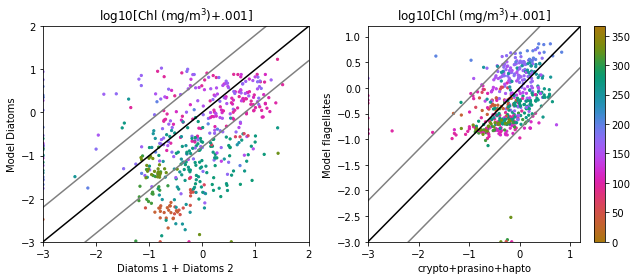

In [47]:
thresh=.8
msize=5
fig,ax=plt.subplots(1,2,figsize=(9,4))
m=ax[0].scatter(logt(data['DD']),logt(data['mod_diatoms_chl']),
          c=data['yd'],s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
m=ax[1].scatter(logt(data['CPH']),logt(data['mod_flagellates_chl']),
          c=data['yd'],s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[0].set_xlim(-3,2)
ax[0].set_ylim(-3,2)
ax[1].set_xlim(-3,1.2)
ax[1].set_ylim(-3,1.2)
ax[0].set_xlabel('Diatoms 1 + Diatoms 2')
ax[0].set_ylabel('Model Diatoms')
ax[0].set_title('log10[Chl (mg/m$^3$)+.001]')
ax[1].set_xlabel('crypto+prasino+hapto')
ax[1].set_ylabel('Model flagellates')
ax[1].set_title('log10[Chl (mg/m$^3$)+.001]')
ax[0].plot((-3,2),(-3+thresh,2+thresh),'-',color='grey')
ax[0].plot((-3,2),(-3-thresh,2-thresh),'-',color='grey')
ax[1].plot((-3,2),(-3+thresh,2+thresh),'-',color='grey')
ax[1].plot((-3,2),(-3-thresh,2-thresh),'-',color='grey')
ax[0].plot((-3,2),(-3,2),'k-')
ax[1].plot((-3,1.2),(-3,1.2),'k-')
plt.tight_layout()
fig.colorbar(m,ax=ax[1])
#fig.suptitle('New')

May-Aug


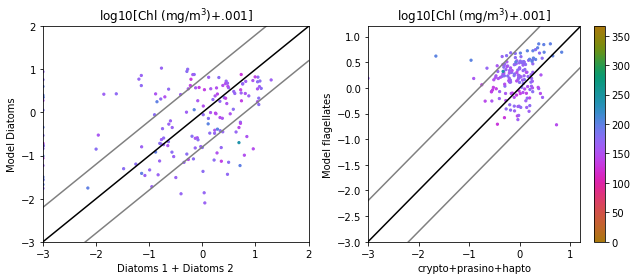

In [63]:
thresh=.8
msize=5
data2=data.loc[(data['yd']>yd(dt.datetime(2015,5,1)))&(data['yd']<yd(dt.datetime(2015,9,1)))]
fig,ax=plt.subplots(1,2,figsize=(9,4))
m=ax[0].scatter(logt(data2['DD']),logt(data2['mod_diatoms_chl']),
          c=data2['yd'],s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
m=ax[1].scatter(logt(data2['CPH']),logt(data2['mod_flagellates_chl']),
          c=data2['yd'],s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[0].set_xlim(-3,2)
ax[0].set_ylim(-3,2)
ax[1].set_xlim(-3,1.2)
ax[1].set_ylim(-3,1.2)
ax[0].set_xlabel('Diatoms 1 + Diatoms 2')
ax[0].set_ylabel('Model Diatoms')
ax[0].set_title('log10[Chl (mg/m$^3$)+.001]')
ax[1].set_xlabel('crypto+prasino+hapto')
ax[1].set_ylabel('Model flagellates')
ax[1].set_title('log10[Chl (mg/m$^3$)+.001]')
ax[0].plot((-3,2),(-3+thresh,2+thresh),'-',color='grey')
ax[0].plot((-3,2),(-3-thresh,2-thresh),'-',color='grey')
ax[1].plot((-3,2),(-3+thresh,2+thresh),'-',color='grey')
ax[1].plot((-3,2),(-3-thresh,2-thresh),'-',color='grey')
ax[0].plot((-3,2),(-3,2),'k-')
ax[1].plot((-3,1.2),(-3,1.2),'k-')
plt.tight_layout()
fig.colorbar(m,ax=ax[1])
#fig.suptitle('New')
print('May-Aug')

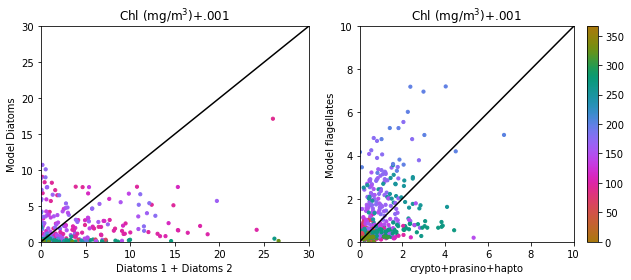

In [48]:
thresh=.8
msize=10
fig,ax=plt.subplots(1,2,figsize=(9,4))
m=ax[0].scatter(data['DD'],data['mod_diatoms_chl'],
          c=data['yd'],s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
m=ax[1].scatter(data['CPH'],data['mod_flagellates_chl'],
          c=data['yd'],s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[0].set_xlim(0,30)
ax[0].set_ylim(0,30)
ax[1].set_xlim(0,10)
ax[1].set_ylim(0,10)
ax[0].set_xlabel('Diatoms 1 + Diatoms 2')
ax[0].set_ylabel('Model Diatoms')
ax[0].set_title('Chl (mg/m$^3$)+.001')
ax[1].set_xlabel('crypto+prasino+hapto')
ax[1].set_ylabel('Model flagellates')
ax[1].set_title('Chl (mg/m$^3$)+.001')
ax[0].plot((0,30),(0,30),'k-')
ax[1].plot((0,10),(0,10),'k-')
plt.tight_layout()
fig.colorbar(m,ax=ax[1])
#fig.suptitle('new')

### Linear fits to deduced groupings

In [49]:
ii=(data['DD']>=0)&(data['mod_diatoms_chl']>=0)
slope, intercept, r_value, p_value, std_err = spst.linregress(data.loc[ii]['DD'],
                                                              data.loc[ii]['mod_diatoms_chl'])

In [50]:
slope, intercept, r_value*r_value

(0.16125795683686217, 0.7946825811125254, 0.10845956227659796)

In [51]:
ii=(data['CPH']>=0)&(data['mod_flagellates_chl']>=0)
slope, intercept, r_value, p_value, std_err = spst.linregress(data.loc[ii]['CPH'],
                                                              data.loc[ii]['mod_flagellates_chl'])

In [52]:
slope, intercept, r_value*r_value

(0.5388676190446141, 0.5426070709199415, 0.1422266760037195)

In [53]:
ii=(data['DD']>=0)&(data['mod_diatoms_chl']>=0)
slope, intercept, r_value, p_value, std_err = spst.linregress(logt(data.loc[ii]['DD']),
                                                              logt(data.loc[ii]['mod_diatoms_chl']))

In [54]:
slope, intercept, r_value*r_value

(0.29762210171936015, -0.6035847692143748, 0.09522667093021238)

### Check for spatial patterns in over/under-estimation

Diatoms/DD


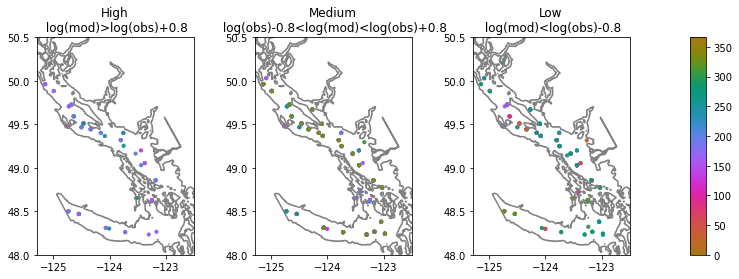

In [55]:
print('Diatoms/DD')
fig,ax=plt.subplots(1,4,figsize=(12,4),gridspec_kw={'width_ratios': [1,1,1,.1],'wspace':.5},)
for iax in ax[0:3]:
    iax.contour(navlon,navlat,tmask[0,:,:],levels=[0.5,],colors='gray')
    iax.set_xlim(-125.3,-122.5)
    iax.set_ylim(48,50.5)
ihi=logt(data['mod_diatoms_chl'])>(logt(data['DD'])+thresh)
ilo=logt(data['mod_diatoms_chl'])<(logt(data['DD'])-thresh)
idata=data.loc[(data.DD>=0)&ihi]
ax[0].scatter(idata.Lon,idata.Lat,c=idata.yd,s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[0].set_title('High\n log(mod)>log(obs)+'+str(thresh))
idata=data.loc[(data.DD>=0)&(~ihi)&(~ilo)]
ax[1].scatter(idata.Lon,idata.Lat,c=idata.yd,s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[1].set_title('Medium\n log(obs)-'+str(thresh)+'<log(mod)<log(obs)+'+str(thresh))
idata=data.loc[(data.DD>=0)&ilo]
m=ax[2].scatter(idata.Lon,idata.Lat,c=idata.yd,s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[2].set_title('Low\n log(mod)<log(obs)-'+str(thresh));
fig.colorbar(m,cax=ax[3]);

Flagellates/CPH


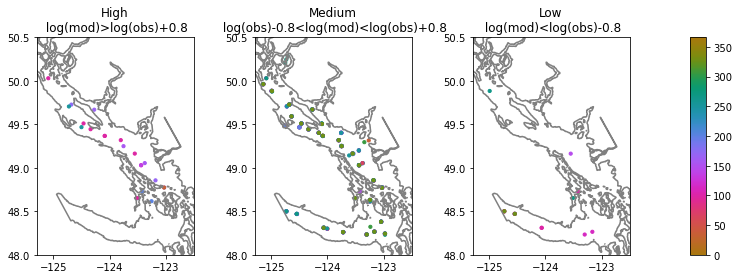

In [56]:
print('Flagellates/CPH')
fig,ax=plt.subplots(1,4,figsize=(12,4),gridspec_kw={'width_ratios': [1,1,1,.1],'wspace':.5},)
for iax in ax[0:3]:
    iax.contour(navlon,navlat,tmask[0,:,:],levels=[0.5,],colors='gray')
    iax.set_xlim(-125.3,-122.5)
    iax.set_ylim(48,50.5)
ihi=logt(data['mod_flagellates_chl'])>(logt(data['CPH'])+thresh)
ilo=logt(data['mod_flagellates_chl'])<(logt(data['CPH'])-thresh)
idata=data.loc[(data.CPH>=0)&ihi]
ax[0].scatter(idata.Lon,idata.Lat,c=idata.yd,s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[0].set_title('High\n log(mod)>log(obs)+'+str(thresh))
idata=data.loc[(data.CPH>=0)&(~ihi)&(~ilo)]
ax[1].scatter(idata.Lon,idata.Lat,c=idata.yd,s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[1].set_title('Medium\n log(obs)-'+str(thresh)+'<log(mod)<log(obs)+'+str(thresh))
idata=data.loc[(data.CPH>=0)&ilo]
m=ax[2].scatter(idata.Lon,idata.Lat,c=idata.yd,s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[2].set_title('Low\n log(mod)<log(obs)-'+str(thresh));
fig.colorbar(m,cax=ax[3]);

### Species composition (fractional) by time of year

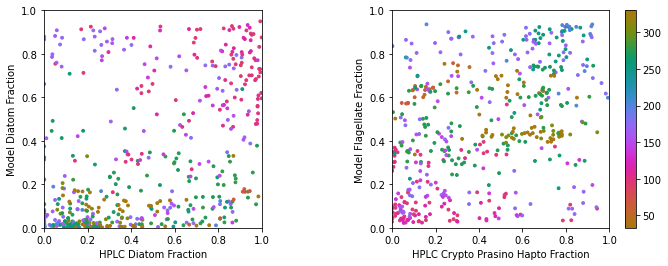

In [57]:
fig,ax=plt.subplots(1,2,figsize=(12,4))
diatFracMod=data['mod_diatoms']/(data['mod_diatoms']+data['mod_flagellates']+data['mod_ciliates'])
diatFracObs=data['DD']/data['TchlA (ug/L)']
m=ax[0].scatter(diatFracObs,diatFracMod,
          c=data['yd'],s=8,cmap=cmocean.cm.phase)
ax[0].set_xlabel('HPLC Diatom Fraction')
ax[0].set_ylabel('Model Diatom Fraction')
ax[0].set_xlim((0,1))
ax[0].set_ylim((0,1))
flFracMod=data['mod_flagellates']/(data['mod_diatoms']+data['mod_flagellates']+data['mod_ciliates'])
CPHFracObs=data['CPH']/data['TchlA (ug/L)']
m=ax[1].scatter(CPHFracObs,flFracMod,
          c=data['yd'],s=8,cmap=cmocean.cm.phase)
ax[1].set_xlabel('HPLC Crypto Prasino Hapto Fraction')
ax[1].set_ylabel('Model Flagellate Fraction')
ax[1].set_xlim((0,1))
ax[1].set_ylim((0,1))
ax[0].set_aspect(1)
ax[1].set_aspect(1)

fig.colorbar(m)

In [58]:
#Reminder:
np.random.seed(42)
df = pd.DataFrame(np.random.randn(1000, 4),columns=['a', 'b', 'c','d'])
df['a+b+c']=.2*df['a']+.3*df['b']+.45*df['c']

In [59]:
df.cov()

,a,b,c,d,a+b+c
a,0.929140,0.007946,-0.037053,-0.022301,0.171538
b,0.007946,1.023910,-0.032939,0.004689,0.293940
c,-0.037053,-0.032939,1.012188,0.034186,0.438192
d,-0.022301,0.004689,0.034186,1.013977,0.012330
a+b+c,0.171538,0.293940,0.438192,0.012330,0.319676


In [60]:
df.corr()

,a,b,c,d,a+b+c
a,1.000000,0.008146,-0.038208,-0.022976,0.314749
b,0.008146,1.000000,-0.032355,0.004602,0.513774
c,-0.038208,-0.032355,1.000000,0.033745,0.770334
d,-0.022976,0.004602,0.033745,1.000000,0.021657
a+b+c,0.314749,0.513774,0.770334,0.021657,1.000000


In [61]:
A=np.vstack([df['a'],df['b'],df['c'],df['d'],np.ones(np.shape(df['a']))]).T
b=df['a+b+c']
m=np.linalg.lstsq(A,b,rcond=None)[0]
print(m)

[ 2.00000000e-01  3.00000000e-01  4.50000000e-01  1.59594560e-16
 -1.00613962e-16]
